The code is fully self-contained. 

The only requirement is to run the Data_Preparation_01_v4 code first and to change the directory in which the data from that file are loaded, sections (1, 5, 6, 7, 10)


-----------------------------------------------------------

# Réseau Convolutionnel Temporel (TCN) implementation for:
# Volatility Prediction and Optimal Asset Allocation

In this code we want to try to predict the Covariance Matrix between the returns of the 8 sectorial ETFs using a Temporal Convolutional Network (TCN)

We will then use the predicted covariance matrix to build an optimized portfolio (using basic optimization techniques), to see if we can actually try to perform better than our benchmark (SP500 & Equally-Weighted Portfolio by sectors).

The results are promising.

In [66]:
import warnings
warnings.filterwarnings("ignore")

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from tqdm.auto import tqdm
import yfinance as yf
import random
import cvxpy as cp
from itertools import product
import optuna
from datetime import datetime

# 1) DATA PREPARATION and Building of Cholesky Training Set

In [68]:
# Load daily ETF log returns
filepath = r"C:\Users\alpor\OneDrive\Desktop\politecnico\CORSI ERASMUS\MACHINE LEARNING\PROGETTO\tcn-portfolio v4\DATA\etf_returns_v4.csv"

# Read Data
df = pd.read_csv(
    filepath,
    index_col=0, parse_dates=True
)
df.dropna(inplace=True)  # Drop remaining NaNs

print("Preview of returns data:")
print(df.head(3))
print("\n\n\n")

# (Optional) Scaling of the returns using MinMax:
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# We'll use unscaled data for covariance
data = df  # or df_scaled if desired
#data = df_scaled


# Definition of Window_size and Sequence_length
# I give as input 63 days worth of returns and therefore of Cholesky decompositions to the TCN. Each Cholesky Decomposition is calculated using the previous 21 days worth of returns.
# I also tried with lower/higher numbers to make the model more dynamic/reduce overfitting

##################################################################

# Number of days used to create a covariance matrix
window_size = 21
# Number of matrixes I give in input to the model
sequence_length = 63

##################################################################

# Rolling window size for covariance
cov_matrices = []
dates = []

for i in range(window_size, len(data)):
    window = data.iloc[i - window_size : i]
    cov = window.cov().values
    # Skip if there's any NaN
    if np.isnan(cov).any():
        continue
    cov_matrices.append(cov)
    dates.append(data.index[i])

cov_matrices = np.stack(cov_matrices)  # shape: (samples, n_assets, n_assets)
print("Found", len(cov_matrices), "valid rolling covariance matrices")
print("\n\n\n")

# Cholesky decomposition (with a small stabilizer on the diagonal to avoid dealing with singular matrixes)
cholesky_list = []
for i, cov in enumerate(cov_matrices):
    try:
        L = np.linalg.cholesky(cov + np.eye(cov.shape[0]) * 1e-8)
        cholesky_list.append(L)
    except np.linalg.LinAlgError:
        pass

cholesky_matrices = np.array(cholesky_list)
print("Total valid Cholesky matrices:", len(cholesky_matrices))
print("\n\n\n")

# Build supervised sequences: X = 63 consecutive Cholesky, y = next day Cholesky

X_list, y_list = [], []
for i in range(sequence_length, len(cholesky_matrices)):
    seq_X = cholesky_matrices[i - sequence_length : i]
    seq_y = cholesky_matrices[i]
    X_list.append(seq_X)
    y_list.append(seq_y)

X = np.stack(X_list)  # shape: (samples, seq_len, n_assets, n_assets)
y = np.stack(y_list)  # shape: (samples, n_assets, n_assets)
print("X.shape =", X.shape, "y.shape =", y.shape)

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)


Preview of returns data:
                 XLE       XLF       XLI       XLK       XLP       XLU  \
Date                                                                     
1999-01-05 -0.005373  0.009291  0.020435  0.025247  0.007512  0.012008   
1999-01-06  0.032464  0.031211  0.021264  0.029120  0.012018  0.010325   
1999-01-07 -0.004573  0.015248 -0.008701 -0.003144 -0.011442 -0.003601   

                 XLV       XLY  
Date                            
1999-01-05  0.015542  0.016707  
1999-01-06  0.016471  0.028006  
1999-01-07 -0.004678 -0.001151  




Found 6579 valid rolling covariance matrices




Total valid Cholesky matrices: 6579




X.shape = (6516, 63, 8, 8) y.shape = (6516, 8, 8)


# 2) DEFINE A DATASET + DATALOADER FOR TRAINING + SETTING SEED

In [69]:
class CholeskyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = CholeskyDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# SETTING A SEED FOR MORE REPRODUCIBILITY

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False




# 3) DEFINE THE TCN MODEL ARCHITECTURE

In [86]:
# ===== DEFINE THE TCN MODEL ARCHITECTURE =====

class TemporalBlock(nn.Module):
    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 kernel_size: int,
                 stride: int,
                 dilation: int,
                 padding: int,
                 activation_cls: type[nn.Module] = nn.ReLU):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(in_channels, out_channels,
                      kernel_size=kernel_size,
                      stride=stride,
                      padding=padding,
                      dilation=dilation),
            activation_cls()
        )

    def forward(self, x):
        return self.net(x)


class TCNModel(nn.Module):
    """
    TCN for predicting next-day Cholesky factor with customizable activations.
    """
    def __init__(self,
                 input_size: int,
                 hidden_size: int,
                 output_size: int,
                 conv_activations: list[type[nn.Module]] = None,
                 linear_activations: list[type[nn.Module]] = None):
        super().__init__()

        # Defaults to [ReLU, ReLU, Tanh] and [ReLU, Identity] if not provided
        if conv_activations is None:
            conv_activations = [nn.Tanh, nn.Tanh, nn.ReLU]
        if linear_activations is None:
            linear_activations = [nn.ReLU, nn.Identity]

        assert len(conv_activations) == 3, "Need 3 conv activations"
        assert len(linear_activations) == 2, "Need 2 linear activations"

        # Build the 3 TCN blocks
        blocks = []
        for i, act_cls in enumerate(conv_activations):
            dilation = 2 ** i
            padding  = dilation
            in_ch    = input_size if i == 0 else hidden_size
            blocks.append(
                TemporalBlock(in_ch, hidden_size,
                              kernel_size=2,
                              stride=1,
                              dilation=dilation,
                              padding=padding,
                              activation_cls=act_cls)
            )
        self.tcn = nn.Sequential(*blocks)

        # Two-layer MLP head
        self.fc1  = nn.Linear(hidden_size, hidden_size // 2)
        self.act1 = linear_activations[0]()
        self.fc2  = nn.Linear(hidden_size // 2, output_size)
        self.act2 = linear_activations[1]()

    def forward(self, x):
        # x: (batch, seq_len, n_assets, n_assets)
        B, seq, n, _ = x.size()
        x = x.view(B, seq, -1).permute(0, 2, 1)   # -> (batch, features, seq_len)
        h = self.tcn(x)[:, :, -1]                 # take last time step

        h = self.fc1(h)
        h = self.act1(h)
        h = self.fc2(h)
        h = self.act2(h)

        return h.view(B, n, n)



# 4) TRAIN THE TCN MODEL

A TCN model is trained using an approach with Walk-Forward Expanding Window.

First some hyperparameter tuning

In [71]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Flexible TCN that takes a list of conv‐layer activations + linear‐head activations ---
class FlexibleTCN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size,
                 conv_activations: list[type[nn.Module]],
                 linear_activations: list[type[nn.Module]]):
        super().__init__()
        # Build TCN blocks
        layers = []
        for i, act_cls in enumerate(conv_activations):
            dilation = 2 ** i
            padding  = dilation
            in_ch    = input_size if i == 0 else hidden_size
            layers += [
                nn.Conv1d(in_ch, hidden_size, kernel_size=2,
                          dilation=dilation, padding=padding),
                act_cls()
            ]
        self.tcn = nn.Sequential(*layers)

        # Two‐layer MLP head
        self.linear = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            linear_activations[0](),
            nn.Linear(hidden_size // 2, output_size),
            linear_activations[1]()
        )

    def forward(self, x):
        b, seq, n, _ = x.size()
        x = x.view(b, seq, -1).permute(0, 2, 1)  # → (B, features, seq)
        h = self.tcn(x)[:, :, -1]                # last time step
        return self.linear(h).view(b, n, n)

# --- Hybrid train + rolling‐validation (unchanged) ---
def hybrid_train_val(model, optimizer, criterion,
                     X, y, epochs=10, initial_pct=0.05, batch_size=32):
    initial_train = int(initial_pct * len(X))
    step          = max(1, (len(X) - initial_train) // epochs)
    val_window    = step
    best_val = float("inf")

    for epoch in range(1, epochs + 1):
        train_end = min(len(X), initial_train + (epoch - 1) * step)
        train_ds  = TensorDataset(X[:train_end], y[:train_end])
        train_ld  = DataLoader(train_ds, batch_size=batch_size, shuffle=False)

        model.train()
        for xb, yb in train_ld:
            pred = model(xb.to(device))
            loss = criterion(pred, yb.to(device))
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        # rolling‐validation
        val_start = train_end
        val_end   = min(len(X), val_start + val_window)
        if val_end > val_start:
            model.eval()
            with torch.no_grad():
                xb = X[val_start:val_end].to(device)
                yb = y[val_start:val_end].to(device)
                val_loss = criterion(model(xb), yb).item()
            best_val = val_loss

    return best_val

# --- Activation map (only ReLU/Tanh) ---
activation_map = {
    "relu": nn.ReLU,
    "tanh": nn.Tanh,
}

# 4 patterns length=2:
conv_patterns = [
    ["relu", "relu"],
    ["relu", "tanh"],
    ["tanh", "relu"],
    ["tanh", "tanh"],
]
# 6 patterns length=3 with exactly one “flip”:
# 3 with two ReLU + one Tanh, and 3 with two Tanh + one ReLU
for base, flip in [("relu", "tanh"), ("tanh", "relu")]:
    for i in range(3):
        patt = [base]*3
        patt[i] = flip
        conv_patterns.append(patt)

# --- Linear‐head patterns (unchanged) ---
linear_patterns = [
    ["relu", "linear"],   # Identity = linear
]

# --- Hyperparameter grid ---
param_grid = {
    "hidden_size":    [32, 64],
    "learning_rate":  [5e-4, 3e-4],
    "conv_pattern":   conv_patterns,
    "linear_pattern": linear_patterns,
}

results = []
for hs, lr, conv_pat, lin_pat in product(
        param_grid["hidden_size"],
        param_grid["learning_rate"],
        param_grid["conv_pattern"],
        param_grid["linear_pattern"]
    ):
    conv_acts = [activation_map[a] for a in conv_pat]
    lin_acts = [
        activation_map[a] if a != "linear" else nn.Identity
        for a in lin_pat
    ]

    model = FlexibleTCN(
        input_size   = df.shape[1]*df.shape[1],
        hidden_size  = hs,
        output_size  = df.shape[1]*df.shape[1],
        conv_activations   = conv_acts,
        linear_activations = lin_acts
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    val_loss = hybrid_train_val(
        model, optimizer, criterion,
        X_tensor, y_tensor,
        epochs=10, initial_pct=0.2, batch_size=64
    )

    config = {
        "Hidden Size"       : hs,
        "Learning Rate"     : lr,
        "Conv Activations"  : conv_pat,
        "Linear Activations": lin_pat,
    }
    print(f"{config} → val_loss={val_loss:.6f}")
    results.append((config, val_loss))

# --- Top 3 models ---
sorted_results = sorted(results, key=lambda x: x[1])
print("\n🔝 Top 3 Models:\n")
for rank, (cfg, vl) in enumerate(sorted_results[:3], start=1):
    print(f"Model #{rank}")
    for k, v in cfg.items():
        print(f"  {k:20s}: {v}")
    print(f"  Validation Loss      : {vl:.6f}")
    print("-"*40)


{'Hidden Size': 32, 'Learning Rate': 0.0005, 'Conv Activations': ['relu', 'relu'], 'Linear Activations': ['relu', 'linear']} → val_loss=0.000006
{'Hidden Size': 32, 'Learning Rate': 0.0005, 'Conv Activations': ['relu', 'tanh'], 'Linear Activations': ['relu', 'linear']} → val_loss=0.000006
{'Hidden Size': 32, 'Learning Rate': 0.0005, 'Conv Activations': ['tanh', 'relu'], 'Linear Activations': ['relu', 'linear']} → val_loss=0.000006
{'Hidden Size': 32, 'Learning Rate': 0.0005, 'Conv Activations': ['tanh', 'tanh'], 'Linear Activations': ['relu', 'linear']} → val_loss=0.000006
{'Hidden Size': 32, 'Learning Rate': 0.0005, 'Conv Activations': ['tanh', 'relu', 'relu'], 'Linear Activations': ['relu', 'linear']} → val_loss=0.000007
{'Hidden Size': 32, 'Learning Rate': 0.0005, 'Conv Activations': ['relu', 'tanh', 'relu'], 'Linear Activations': ['relu', 'linear']} → val_loss=0.000006
{'Hidden Size': 32, 'Learning Rate': 0.0005, 'Conv Activations': ['relu', 'relu', 'tanh'], 'Linear Activations': [

Let's conduct more thorough training of our best model. 

We use an hybrid training logic with a Walk-forward validation with expanding window. Hybrid because there is an expanding window of training with a rolling validation (not a classic fixed train/split)

In [87]:
# Decide device once
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("→ Running on", device)

# ===== Setting the Seed =====
set_seed(4120)  # 4120 or 100

# ===== MODEL & OPTIMIZER =====
n_assets    = df.shape[1]
input_size  = n_assets * n_assets
hidden_size = 64
output_size = input_size
"""
# Use the FlexibleTCN so we can specify mixed activations:
model = FlexibleTCN(
    input_size=input_size,
    hidden_size=hidden_size,
    output_size=output_size,
    conv_activations=[nn.ReLU, nn.ReLU, nn.Tanh],    # ← [ReLU, ReLU, Tanh]
    linear_activations=[nn.ReLU, nn.Identity]        # ← [ReLU, Linear]
).to(device)
"""

model = TCNModel(input_size, hidden_size, output_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0004) 
criterion = nn.MSELoss()

# ===== HYBRID HYPERPARAMETERS =====
epochs             = 25
initial_pct        = 0.2
initial_train_size = int(initial_pct * len(X_tensor))
step               = max(1, (len(X_tensor) - initial_train_size) // epochs)
val_window         = step  # same rolling window for validation

# ===== TRAIN + ROLLING VALIDATION =====
for epoch in range(1, epochs + 1):
    # 1) expanding the training set
    train_end    = min(len(X_tensor), initial_train_size + (epoch - 1) * step)
    train_ds     = TensorDataset(X_tensor[:train_end], y_tensor[:train_end])
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=False)

    model.train()
    total_loss = 0.0
    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}", leave=False):
        xb, yb = xb.to(device), yb.to(device)
        pred   = model(xb)
        loss   = criterion(pred, yb)

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # 2) rolling validation immediately after the current training block
    val_start = train_end
    val_end   = min(len(X_tensor), val_start + val_window)
    if val_end > val_start:
        model.eval()
        X_val = X_tensor[val_start:val_end].to(device)
        y_val = y_tensor[val_start:val_end].to(device)
        with torch.no_grad():
            val_pred = model(X_val)
            val_loss = criterion(val_pred, y_val).item()
    else:
        val_loss = float("nan")

    print(
        f"Epoch {epoch:2d} | "
        f"train_samples={train_end:5d} | "
        f"train_loss={avg_train_loss:.6f} | "
        f"val_loss={val_loss:.6f}"
    )


→ Running on cuda


Epoch 1/25:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch  1 | train_samples= 1303 | train_loss=0.005931 | val_loss=0.002669


Epoch 2/25:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch  2 | train_samples= 1511 | train_loss=0.001203 | val_loss=0.000310


Epoch 3/25:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch  3 | train_samples= 1719 | train_loss=0.000112 | val_loss=0.000019


Epoch 4/25:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch  4 | train_samples= 1927 | train_loss=0.000014 | val_loss=0.000004


Epoch 5/25:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch  5 | train_samples= 2135 | train_loss=0.000010 | val_loss=0.000016


Epoch 6/25:   0%|          | 0/74 [00:00<?, ?it/s]

Epoch  6 | train_samples= 2343 | train_loss=0.000010 | val_loss=0.000083


Epoch 7/25:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch  7 | train_samples= 2551 | train_loss=0.000015 | val_loss=0.000028


Epoch 8/25:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch  8 | train_samples= 2759 | train_loss=0.000019 | val_loss=0.000020


Epoch 9/25:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch  9 | train_samples= 2967 | train_loss=0.000017 | val_loss=0.000014


Epoch 10/25:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 10 | train_samples= 3175 | train_loss=0.000017 | val_loss=0.000006


Epoch 11/25:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch 11 | train_samples= 3383 | train_loss=0.000016 | val_loss=0.000004


Epoch 12/25:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 12 | train_samples= 3591 | train_loss=0.000015 | val_loss=0.000003


Epoch 13/25:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 13 | train_samples= 3799 | train_loss=0.000014 | val_loss=0.000004


Epoch 14/25:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 14 | train_samples= 4007 | train_loss=0.000013 | val_loss=0.000006


Epoch 15/25:   0%|          | 0/132 [00:00<?, ?it/s]

Epoch 15 | train_samples= 4215 | train_loss=0.000013 | val_loss=0.000004


Epoch 16/25:   0%|          | 0/139 [00:00<?, ?it/s]

Epoch 16 | train_samples= 4423 | train_loss=0.000012 | val_loss=0.000005


Epoch 17/25:   0%|          | 0/145 [00:00<?, ?it/s]

Epoch 17 | train_samples= 4631 | train_loss=0.000011 | val_loss=0.000004


Epoch 18/25:   0%|          | 0/152 [00:00<?, ?it/s]

Epoch 18 | train_samples= 4839 | train_loss=0.000011 | val_loss=0.000006


Epoch 19/25:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch 19 | train_samples= 5047 | train_loss=0.000011 | val_loss=0.000014


Epoch 20/25:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 20 | train_samples= 5255 | train_loss=0.000012 | val_loss=0.000039


Epoch 21/25:   0%|          | 0/171 [00:00<?, ?it/s]

Epoch 21 | train_samples= 5463 | train_loss=0.000012 | val_loss=0.000010


Epoch 22/25:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 22 | train_samples= 5671 | train_loss=0.000012 | val_loss=0.000012


Epoch 23/25:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 23 | train_samples= 5879 | train_loss=0.000012 | val_loss=0.000006


Epoch 24/25:   0%|          | 0/191 [00:00<?, ?it/s]

Epoch 24 | train_samples= 6087 | train_loss=0.000011 | val_loss=0.000006


Epoch 25/25:   0%|          | 0/197 [00:00<?, ?it/s]

Epoch 25 | train_samples= 6295 | train_loss=0.000010 | val_loss=0.000005



# 5) SAVE & RELOAD THE MODEL WEIGHTS

In [88]:
# 1) Save the trained model
weights_path = r"C:\Users\alpor\OneDrive\Desktop\politecnico\CORSI ERASMUS\MACHINE LEARNING\PROGETTO\tcn-portfolio v4\MODEL\tcn_cholesky_v4_weights.pth"

torch.save(model.state_dict(), weights_path)
print(f"✅ Model weights saved to {weights_path}")

# 2) Architecture
model = TCNModel(input_size, hidden_size, output_size).to(device)

# 3) Load weights & move model to device
state = torch.load(weights_path, map_location=device)
model.load_state_dict(state)
model = model.to(device)
model.eval()

print("✅ Model reloaded and moved to", device)


✅ Model weights saved to C:\Users\alpor\OneDrive\Desktop\politecnico\CORSI ERASMUS\MACHINE LEARNING\PROGETTO\tcn-portfolio v4\MODEL\tcn_cholesky_v4_weights.pth
✅ Model reloaded and moved to cuda


# 6) BACKTEST LOOP USING GLOBAL AVERAGE FOR mu_pred

Hyperparameter tuning for alpha, beta, gamma

In [74]:
# ──────────────────────────────────────────────────────────────────────────────
# 1) CARICAMENTO DATI E MODELLO
# ──────────────────────────────────────────────────────────────────────────────

returns_path = r"C:\Users\alpor\OneDrive\Desktop\politecnico\CORSI ERASMUS\MACHINE LEARNING\PROGETTO\tcn-portfolio v4\DATA\etf_returns_v4.csv"
returns = pd.read_csv(returns_path, index_col=0, parse_dates=True)
returns.replace([np.inf, -np.inf], np.nan, inplace=True)
returns.dropna(inplace=True)
etf_columns = returns.columns.tolist()

# costi fissi
transaction_cost = 0.195 / 100
slippage        = 0.025   / 100
c_base          = transaction_cost + slippage

# vincoli e sequenze
lb, ub      = -0.25, 0.5
seq_len     = 180
window_size = seq_len

# device PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- il tuo modello già addestrato ---
# model = torch.load("path_to_model.pt")
# model.to(device)
# model.eval()

# ──────────────────────────────────────────────────────────────────────────────
# 2) FUNZIONI DI PREDIZIONE E BACKTEST
# ──────────────────────────────────────────────────────────────────────────────

def predict_next_day_cov(model, i, returns_df, seq_len):
    cov_input = []
    for j in range(i - seq_len, i):
        window = returns_df.iloc[j - seq_len : j]
        cov = window.cov().values
        L = np.linalg.cholesky(cov + np.eye(cov.shape[0]) * 1e-7)
        cov_input.append(torch.tensor(L, dtype=torch.float32, device=device))
    x_cov = torch.stack(cov_input).unsqueeze(0)
    with torch.no_grad():
        L_pred = model(x_cov)
        cov_pred = (
            torch.bmm(L_pred, L_pred.transpose(1,2))
            .squeeze(0)
            .cpu()
            .numpy()
        )
    return cov_pred + np.eye(cov_pred.shape[0]) * 1e-7

def predict_next_day_global(model, i, returns_df, cov_length):
    mu_pred  = returns_df.mean().values
    cov_pred = predict_next_day_cov(model, i, returns_df, seq_len=cov_length)
    return mu_pred, cov_pred

def turnover_penalized_weights(mu, cov, w_prev, alpha, gamma, turnover_cost, beta, lb, ub):
    n = len(mu)
    w = cp.Variable(n)
    # mix L1/L2
    cost_turn = alpha * cp.norm1(w - w_prev) + (1 - alpha) * cp.sum_squares(w - w_prev)
    obj = cp.Maximize(
        mu @ w
        - (gamma / 2) * cp.quad_form(w, cov)
        - beta * turnover_cost * cost_turn
    )
    constraints = [cp.sum(w) == 1, w >= lb, w <= ub]
    prob = cp.Problem(obj, constraints)
    prob.solve(solver=cp.SCS, verbose=False)
    return w.value

def run_backtest(model, returns, alpha, gamma, beta):
    start_index     = window_size + seq_len
    equal_weights   = np.repeat(1 / len(etf_columns), len(etf_columns))
    portfolio_value = 100.0
    benchmark_value = 100.0
    commissions     = 0.0

    dates = []
    pv    = []
    bv    = []

    for i in range(start_index, len(returns) - 1):
        mu, cov = predict_next_day_global(model, i, returns, cov_length=seq_len)

        # shrinkage momentum
        shrink_alpha = 0.025
        spans = [30, 90, 180]
        mu_short = sum(
            returns.iloc[i - seq_len : i]
                   .ewm(span=span, adjust=False)
                   .mean()
                   .iloc[-1]
                   .values
            for span in spans
        )
        mu = (1 - 3 * shrink_alpha) * mu + shrink_alpha * mu_short

        w_prev = equal_weights if i == start_index else weights
        weights = turnover_penalized_weights(
            mu, cov, w_prev, alpha, gamma, c_base, beta, lb, ub
        )
        weights = np.clip(weights, lb, ub)
        weights /= weights.sum()

        real_ret = returns.iloc[i + 1].values
        turnover = np.sum(np.abs(weights - w_prev))

        V_old = portfolio_value
        cost   = c_base * turnover if turnover >= 0.01 else 0.0

        portfolio_value = V_old * (1 - cost) * np.exp(weights @ real_ret)
        commissions    += V_old * cost
        benchmark_value *= np.exp(equal_weights @ real_ret)

        dates.append(returns.index[i + 1])
        pv.append(portfolio_value)
        bv.append(benchmark_value)

    return pd.DataFrame({'portfolio_value': pv, 'benchmark_value': bv}, index=dates)

# ──────────────────────────────────────────────────────────────────────────────
# 3) DEFINIZIONE DELLA FUNZIONE OBIETTIVO
# ──────────────────────────────────────────────────────────────────────────────

def objective(trial):
    beta  = trial.suggest_float("beta",  0.5, 1.5)
    alpha = trial.suggest_float("alpha", 0.2, 0.8)
    gamma = trial.suggest_float("gamma", 1, 4)

    perf = run_backtest(model, returns, alpha, gamma, beta)
    net  = perf['portfolio_value'].pct_change().dropna()
    sharpe = net.mean() / net.std() * np.sqrt(252)

    return sharpe

# ──────────────────────────────────────────────────────────────────────────────
# 4) ESECUZIONE DELLO STUDIO OPTUNA
# ──────────────────────────────────────────────────────────────────────────────

if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(
        objective,
        n_trials=20,
        timeout=100 * 60  # 45 minuti
    )

    print("MIGLIORI IPERPARAMETRI:")
    print(f"  beta:  {study.best_params['beta']:.4f}")
    print(f"  alpha: {study.best_params['alpha']:.4f}")
    print(f"  gamma: {study.best_params['gamma']:.4f}")
    print(f"Sharpe: {study.best_value:.4f}")


[I 2025-07-21 15:42:46,342] A new study created in memory with name: no-name-37b0c949-ed02-41f3-807d-3f95bbdb5bfa
[I 2025-07-21 15:49:18,360] Trial 0 finished with value: 0.5005903641973676 and parameters: {'beta': 1.3387283551973748, 'alpha': 0.7860140758673122, 'gamma': 1.6321410891515475}. Best is trial 0 with value: 0.5005903641973676.
[I 2025-07-21 15:55:33,119] Trial 1 finished with value: 0.5004157978664407 and parameters: {'beta': 0.6622551407146161, 'alpha': 0.5893568344510641, 'gamma': 1.3708620285813975}. Best is trial 0 with value: 0.5005903641973676.
[I 2025-07-21 16:01:47,106] Trial 2 finished with value: 0.4955515814703124 and parameters: {'beta': 1.09859394203836, 'alpha': 0.2737181928292389, 'gamma': 1.2998861474575578}. Best is trial 0 with value: 0.5005903641973676.
[I 2025-07-21 16:07:59,236] Trial 3 finished with value: 0.5005375533302857 and parameters: {'beta': 1.3974466044143319, 'alpha': 0.3879834450388336, 'gamma': 1.4839538299206303}. Best is trial 0 with val

MIGLIORI IPERPARAMETRI:
  beta:  1.3387
  alpha: 0.7860
  gamma: 1.6321
Sharpe: 0.5006


Backtesting Optimal Model

In [89]:
returns_path = r"C:\Users\alpor\OneDrive\Desktop\politecnico\CORSI ERASMUS\MACHINE LEARNING\PROGETTO\tcn-portfolio v4\DATA\etf_returns_v4.csv"

returns = pd.read_csv(returns_path, index_col=0, parse_dates=True)
etf_columns = returns.columns.tolist()
returns.replace([np.inf, -np.inf], np.nan, inplace=True)
returns.dropna(inplace=True)
print("✅ Log returns loaded. Shape:", returns.shape)

def predict_next_day_cov(model, i, returns_df, seq_len):  # seq_len=63
    """
    Predict next-day covariance from the last 'seq_len' Cholesky factors.
    """
    cov_input = []
    for j in range(i - seq_len, i):
        window = returns_df.iloc[j - seq_len : j]
        cov = window.cov().values
        L = np.linalg.cholesky(cov + np.eye(cov.shape[0]) * 1e-7)
        cov_input.append(torch.tensor(L, dtype=torch.float32, device=device))

    x_cov = torch.stack(cov_input).unsqueeze(0)  # shape (1, seq_len, n_assets, n_assets)

    with torch.no_grad():
        L_pred = model(x_cov)  # both model and x_cov on `device`
        cov_pred = (
            torch.bmm(L_pred, L_pred.transpose(1, 2))
            .squeeze(0)
            .cpu()
            .numpy()
        )

    cov_pred += np.eye(cov_pred.shape[0]) * 1e-7  # numerical stability
    return cov_pred

def predict_next_day_global(i, returns_df, cov_length=180):
    """
    Compute global average returns and TCN-based covariance.
    """
    # 1) Global average for mu
    mu_pred = returns_df.mean().values

    # 2) TCN-based covariance using the main `model`
    cov_pred = predict_next_day_cov(model, i, returns_df, seq_len=cov_length)
    return mu_pred, cov_pred

# transaction cost per unit turnover 
transaction_cost = 0.195 / 100  # 0.195% is realistic for a retail investor; 0.05% for an institutional
slippage = 0.025 / 100 # could be interesting to apply a dynamic one
c = transaction_cost + slippage
# risk aversion
gamma = 4.5
# box constraints
lb, ub = -0.5, 0.75

def turnover_penalized_weights(mu, cov, w_prev, gamma, turnover_cost, lb, ub):
    alpha = 0.3 # mix L1/L2: 1=L1, 0=L2
    beta = 0.6 # choosen with hyperparameter tuning
    n = len(mu)
    w = cp.Variable(n)

    cost_turn = alpha * cp.norm1(w - w_prev) + (1 - alpha) * cp.sum_squares(w - w_prev)
    obj = cp.Maximize(
        mu @ w
        - (gamma / 2) * cp.quad_form(w, cov)
        - beta * turnover_cost * cost_turn
    )
    constraints = [cp.sum(w) == 1, w >= lb, w <= ub]
    prob = cp.Problem(obj, constraints)
    prob.solve(solver=cp.SCS, verbose=False)
    return w.value

# start your backtest
start_index = window_size + sequence_length

weights_list = []
returns_list = []
dates = []
portfolio_value = 100.0
portfolio_values = []

equal_weights = np.repeat(1 / len(etf_columns), len(etf_columns))
benchmark_value = 100.0
benchmark_values = []
commissions = 0

for i in range(start_index, len(returns) - 1):
    if i % 10 == 0:
        print(f"\n🔁 Iteration {i}/{len(returns) - 1}")

    # 1) predict mu and covariance
    mu_pred, _ = predict_next_day_global(i, returns, cov_length=sequence_length)
    cov_pred = predict_next_day_cov(model, i, returns, seq_len=sequence_length)

    # 2) Smoothed momentum-style expected returns (Shrinkage)
    shrink_alpha = 0.02
    spans = [30, 90, 180]
    mu_long = mu_pred
    mu_short = sum(
        returns.iloc[i - sequence_length : i]
               .ewm(span=span, adjust=False)
               .mean()
               .iloc[-1]
               .values
        for span in spans
    )
    mu_pred = (1 - 3 * shrink_alpha) * mu_long + shrink_alpha * mu_short

    # 3) previous weights (or equal for first day)
    w_prev = weights_list[-1] if weights_list else equal_weights

    # 4) solve the turnover‐penalized QP
    weights = turnover_penalized_weights(
        mu_pred, cov_pred, w_prev, gamma, c, lb, ub
    )

    # 5) normalize & clip
    weights = np.clip(weights, lb, ub)
    weights /= weights.sum()

    # 6) next‐day return minus transaction cost
    real_ret = returns.iloc[i + 1].values
    turnover = np.sum(np.abs(weights - w_prev))
    if turnover < 0.01:
        weights, turnover, cost = w_prev, 0.0, 0.0
        portfolio_log_ret = weights @ real_ret
        cost = 0
    else:
        cost = c * turnover
        portfolio_log_ret = weights @ real_ret

    # 7) update portfolio
    portfolio_value *= np.exp(portfolio_log_ret)
    portfolio_value *= (1 - cost)
    portfolio_values.append(portfolio_value)
    returns_list.append(portfolio_log_ret)
    dates.append(returns.index[i + 1])
    weights_list.append(weights)
    commissions += portfolio_value * cost

    # benchmark (no turnover cost)
    benchmark_log_ret = equal_weights @ real_ret
    benchmark_value *= np.exp(benchmark_log_ret)
    benchmark_values.append(benchmark_value)

    if i % 10 == 0:
        print(f"   ✅ Portf: {portfolio_value:.2f}, Bmk: {benchmark_value:.2f}")
        print("Total commissions:", commissions)

# Save results
performance = pd.DataFrame({
    'date': dates,
    'portfolio_value': portfolio_values,
    'benchmark_value': benchmark_values,
    'portfolio_return': returns_list
}).set_index('date')

performance_csv = r"C:\Users\alpor\OneDrive\Desktop\politecnico\CORSI ERASMUS\MACHINE LEARNING\PROGETTO\tcn-portfolio v4\DATA\tangent_vs_benchmark_performance.csv"
performance.to_csv(performance_csv)
print(f"📁 Saved performance results to {performance_csv}")

trade_history = pd.DataFrame(weights_list, columns=etf_columns, index=dates)
trade_history.index.name = "date"
trade_history.to_csv(r"C:\Users\alpor\OneDrive\Desktop\politecnico\CORSI ERASMUS\MACHINE LEARNING\PROGETTO\tcn-portfolio v4\DATA\weights_history_backtest.csv")
print("📁 Weights history saved to weights_history_backtest.csv")


✅ Log returns loaded. Shape: (6600, 8)

🔁 Iteration 90/6599
   ✅ Portf: 100.20, Bmk: 100.39
Total commissions: 0.025684205680656522

🔁 Iteration 100/6599
   ✅ Portf: 97.45, Bmk: 97.57
Total commissions: 0.03566509872597907

🔁 Iteration 110/6599
   ✅ Portf: 99.49, Bmk: 98.94
Total commissions: 0.05623717206655515

🔁 Iteration 120/6599
   ✅ Portf: 100.40, Bmk: 100.83
Total commissions: 0.05623717206655515

🔁 Iteration 130/6599
   ✅ Portf: 103.54, Bmk: 103.79
Total commissions: 0.05623717206655515

🔁 Iteration 140/6599
   ✅ Portf: 101.73, Bmk: 101.90
Total commissions: 0.10824914155108258

🔁 Iteration 150/6599
   ✅ Portf: 98.40, Bmk: 97.53
Total commissions: 0.10824914155108258

🔁 Iteration 160/6599
   ✅ Portf: 102.45, Bmk: 102.59
Total commissions: 0.10824914155108258

🔁 Iteration 170/6599
   ✅ Portf: 100.18, Bmk: 99.56
Total commissions: 0.10824914155108258

🔁 Iteration 180/6599
   ✅ Portf: 96.30, Bmk: 95.76
Total commissions: 0.12252925192532467

🔁 Iteration 190/6599
   ✅ Portf: 97.60,


# 7) ADD S&P500 AND COMPUTE METRICS


In [90]:
# Download of SPY data (ETF on SP500), and metrics calculation
spy = yf.download(
    "SPY",
    start=performance.index[0].strftime('%Y-%m-%d'),
    end=performance.index[-1].strftime('%Y-%m-%d')
)
spy['log_return'] = np.log(spy['Close'] / spy['Close'].shift(1))
spy['value'] = 100 * np.exp(spy['log_return'].fillna(0).cumsum())

def compute_metrics(series):
    log_ret = np.log(series / series.shift(1)).dropna()
    cumulative_return = series.iloc[-1] / series.iloc[0] - 1
    volatility = log_ret.std() * np.sqrt(252)
    sharpe = (log_ret.mean() / log_ret.std()) * np.sqrt(252)
    drawdown = series / series.cummax() - 1
    max_drawdown = drawdown.min()
    return cumulative_return, volatility, sharpe, max_drawdown

port_metrics = compute_metrics(performance['portfolio_value'])
bmk_metrics = compute_metrics(performance['benchmark_value'])
spy_metrics = compute_metrics(spy['value'])

print("\n📊 Performance Metrics:")
print("TCN Portfolio      → Return: {:.2%}, Volatility: {:.2%}, Sharpe: {:.2f}, Max DD: {:.2%}".format(*port_metrics))
print("Benchmark          → Return: {:.2%}, Volatility: {:.2%}, Sharpe: {:.2f}, Max DD: {:.2%}".format(*bmk_metrics))
print("S&P 500            → Return: {:.2%}, Volatility: {:.2%}, Sharpe: {:.2f}, Max DD: {:.2%}".format(*spy_metrics))

metrics_df = pd.DataFrame({
    'Portfolio': ['TCN Portfolio', 'Benchmark', 'SPY'],
    'Return': [port_metrics[0], bmk_metrics[0], spy_metrics[0]],
    'Volatility': [port_metrics[1], bmk_metrics[1], spy_metrics[1]],
    'Sharpe Ratio': [port_metrics[2], bmk_metrics[2], spy_metrics[2]],
    'Max Drawdown': [port_metrics[3], bmk_metrics[3], spy_metrics[3]]
})
metrics_df_path = r"C:\Users\alpor\OneDrive\Desktop\politecnico\CORSI ERASMUS\MACHINE LEARNING\PROGETTO\tcn-portfolio v4\DATA\Performance_metrics.csv"
metrics_df.to_csv(metrics_df_path, index=False)
print(f"📁 Metrics saved to {metrics_df_path}")


[*********************100%***********************]  1 of 1 completed


📊 Performance Metrics:
TCN Portfolio      → Return: 702.87%, Volatility: 17.81%, Sharpe: 0.45, Max DD: -38.84%
Benchmark          → Return: 550.85%, Volatility: 18.13%, Sharpe: 0.40, Max DD: -54.21%
S&P 500            → Return: 553.14%, Volatility: 19.31%, Sharpe: 0.38, Max DD: -55.19%
📁 Metrics saved to C:\Users\alpor\OneDrive\Desktop\politecnico\CORSI ERASMUS\MACHINE LEARNING\PROGETTO\tcn-portfolio v4\DATA\Performance_metrics.csv


# 8) PLOT RESULTS

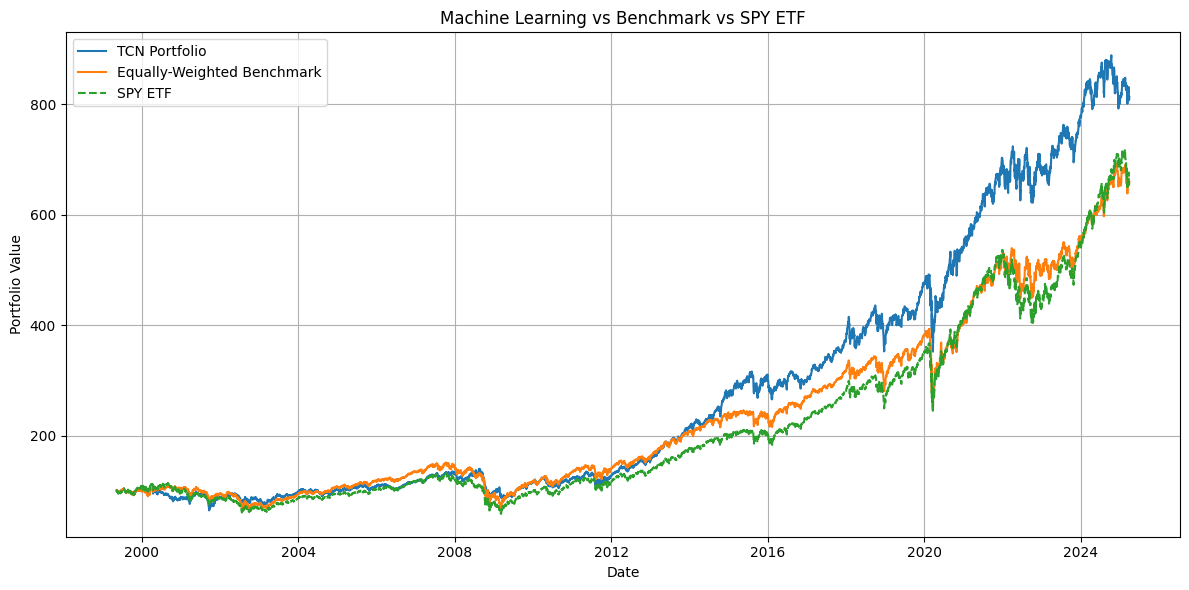


✅ Backtest complete.
Max log return: 0.1525034416184086
Min log return: -0.2249097392625117


In [91]:
plt.figure(figsize=(12, 6))
plt.plot(performance.index, performance['portfolio_value'], label='TCN Portfolio')
plt.plot(performance.index, performance['benchmark_value'], label='Equally-Weighted Benchmark')
plt.plot(spy.index, spy['value'], label='SPY ETF', linestyle='--')
plt.title("Machine Learning vs Benchmark vs SPY ETF")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n✅ Backtest complete.")
print("Max log return:", returns.max().max())
print("Min log return:", returns.min().min())


# 9) ROLLING MONTE CARLO SIMULATION FOR ES E VaR

In [92]:
# Load Weights history (generated from backtest)
weights_history_path = r"C:\Users\alpor\OneDrive\Desktop\politecnico\CORSI ERASMUS\MACHINE LEARNING\PROGETTO\tcn-portfolio v4\DATA\weights_history_backtest.csv"
weights_history = pd.read_csv(weights_history_path, index_col=0, parse_dates=True)

# fix indexes
weights_history = weights_history.sort_index()
# returns
df = df.sort_index()
returns_df = df


VaR medio: -0.0298
ES medio : -0.0456


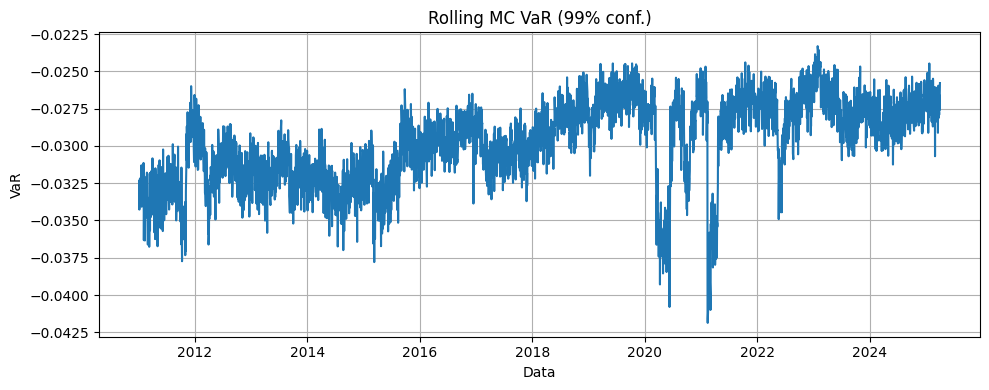

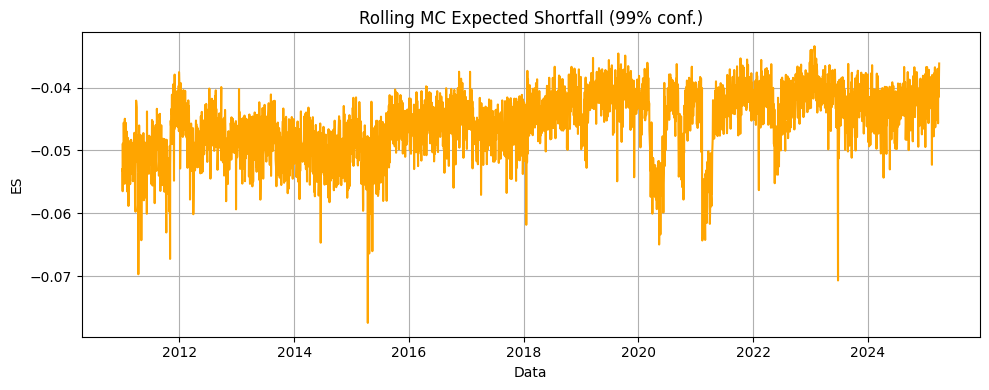

In [99]:
# === CONFIGURAZIONE ===
sequence_length   = 63
# predict_next_day_global fa internamente 63+63 passi indietro
required_history  = 2 * sequence_length

start_date        = pd.to_datetime("2011-01-04")
n_simulations     = 10000
confidence_level  = 0.99
use_t_dist        = True
df_t              = 3

# === FUNZIONE MONTECARLO VAR/ES ===
def montecarlo_var_es(model, returns_df, i, weights,
                      n_simulations=10000,
                      confidence_level=0.99,
                      use_t_dist=True,
                      df_t=5):
    # hack per far sì che dentro predict_next_day_global
    # “returns” punti a returns_df
    predict_next_day_global.__globals__['returns'] = returns_df

    mu_pred, cov_pred = predict_next_day_global(i, returns_df, cov_length=sequence_length)
    mu_pred = np.array(mu_pred)
    cov_pred = np.array(cov_pred)

    if use_t_dist:
        # t-dist tramite scala-mixture di gaussiane
        g = np.random.gamma(df_t/2., 2./df_t, size=n_simulations)
        Z = np.random.multivariate_normal(np.zeros_like(mu_pred), cov_pred, size=n_simulations)
        simulated = mu_pred + Z/np.sqrt(g)[:, None]
    else:
        simulated = np.random.multivariate_normal(mu_pred, cov_pred, size=n_simulations)

    portf_ret = simulated @ weights
    losses    = -portf_ret

    alpha = 1 - confidence_level
    sorted_losses = np.sort(losses)
    cutoff = int(alpha * len(sorted_losses))
    VaR = sorted_losses[cutoff]
    ES = sorted_losses[:cutoff].mean()

    return VaR, ES

# === PREPARAZIONE DATE VALIDE ===
# prendi tutte le date con indice ≥ required_history
valid_dates = returns_df.index[required_history:]
# tieni solo quelle presenti anche nei pesi
valid_dates = valid_dates.intersection(weights_history.index)
# filtra per start_date
rolling_index = valid_dates[valid_dates >= start_date].sort_values()

# === ROLLING MONTECARLO ===
var_list   = []
es_list    = []
date_list  = []

for date in rolling_index:
    i       = returns_df.index.get_loc(date)
    weights = weights_history.loc[date].values

    VaR, ES = montecarlo_var_es(
        model=model,
        returns_df=returns_df,
        i=i,
        weights=weights,
        n_simulations=n_simulations,
        confidence_level=confidence_level,
        use_t_dist=use_t_dist,
        df_t=df_t
    )

    var_list.append(VaR)
    es_list.append(ES)
    date_list.append(date)

# === RISULTATI ===
rolling_risk_df = pd.DataFrame({
    'VaR': var_list,
    'ES' : es_list
}, index=date_list)

# Calcolo dei valori medi
mean_var = rolling_risk_df['VaR'].mean()
mean_es  = rolling_risk_df['ES'].mean()

# Stampa dei risultati
print(f"VaR medio: {mean_var:.4f}")
print(f"ES medio : {mean_es:.4f}") 

# --- (opzionale) plot rolling VaR ed ES ---

# — Grafico VaR —
plt.figure(figsize=(10, 4))
plt.plot(rolling_risk_df.index, rolling_risk_df['VaR'])
plt.title('Rolling MC VaR (99% conf.)')
plt.xlabel('Data')
plt.ylabel('VaR')
plt.grid(True)
plt.tight_layout()
plt.show()

# — Grafico ES —
plt.figure(figsize=(10, 4))
plt.plot(rolling_risk_df.index, rolling_risk_df['ES'], color='orange')
plt.title('Rolling MC Expected Shortfall (99% conf.)')
plt.xlabel('Data')
plt.ylabel('ES')
plt.grid(True)
plt.tight_layout()
plt.show()


In [100]:
# Ricava i rendimenti reali del portafoglio
portf_ret = (returns_df * weights_history).sum(axis=1)

# Allinea con i giorni validi
test_rets = portf_ret.loc[rolling_risk_df.index]

# Breaches e coverage
breaches = test_rets[test_rets < rolling_risk_df['VaR']]
coverage = len(breaches) / len(rolling_risk_df)
print('Copertura eccezioni:', coverage)

# ES empirica
empirical_es = breaches.mean()
print('Expected Shortfall empirica:', empirical_es)


Copertura eccezioni: 0.009773806199385646
Expected Shortfall empirica: -0.04163988257106247


# 10) PLOTTING AN EXAMPLE OF AN ACTUAL VS PREDICTED COVARIANCE MATRIX

Index 450: MAE × 10 000 = 0.67
Index 800: MAE × 10 000 = 0.47
Index 1140: MAE × 10 000 = 0.34
Index 6100: MAE × 10 000 = 0.30


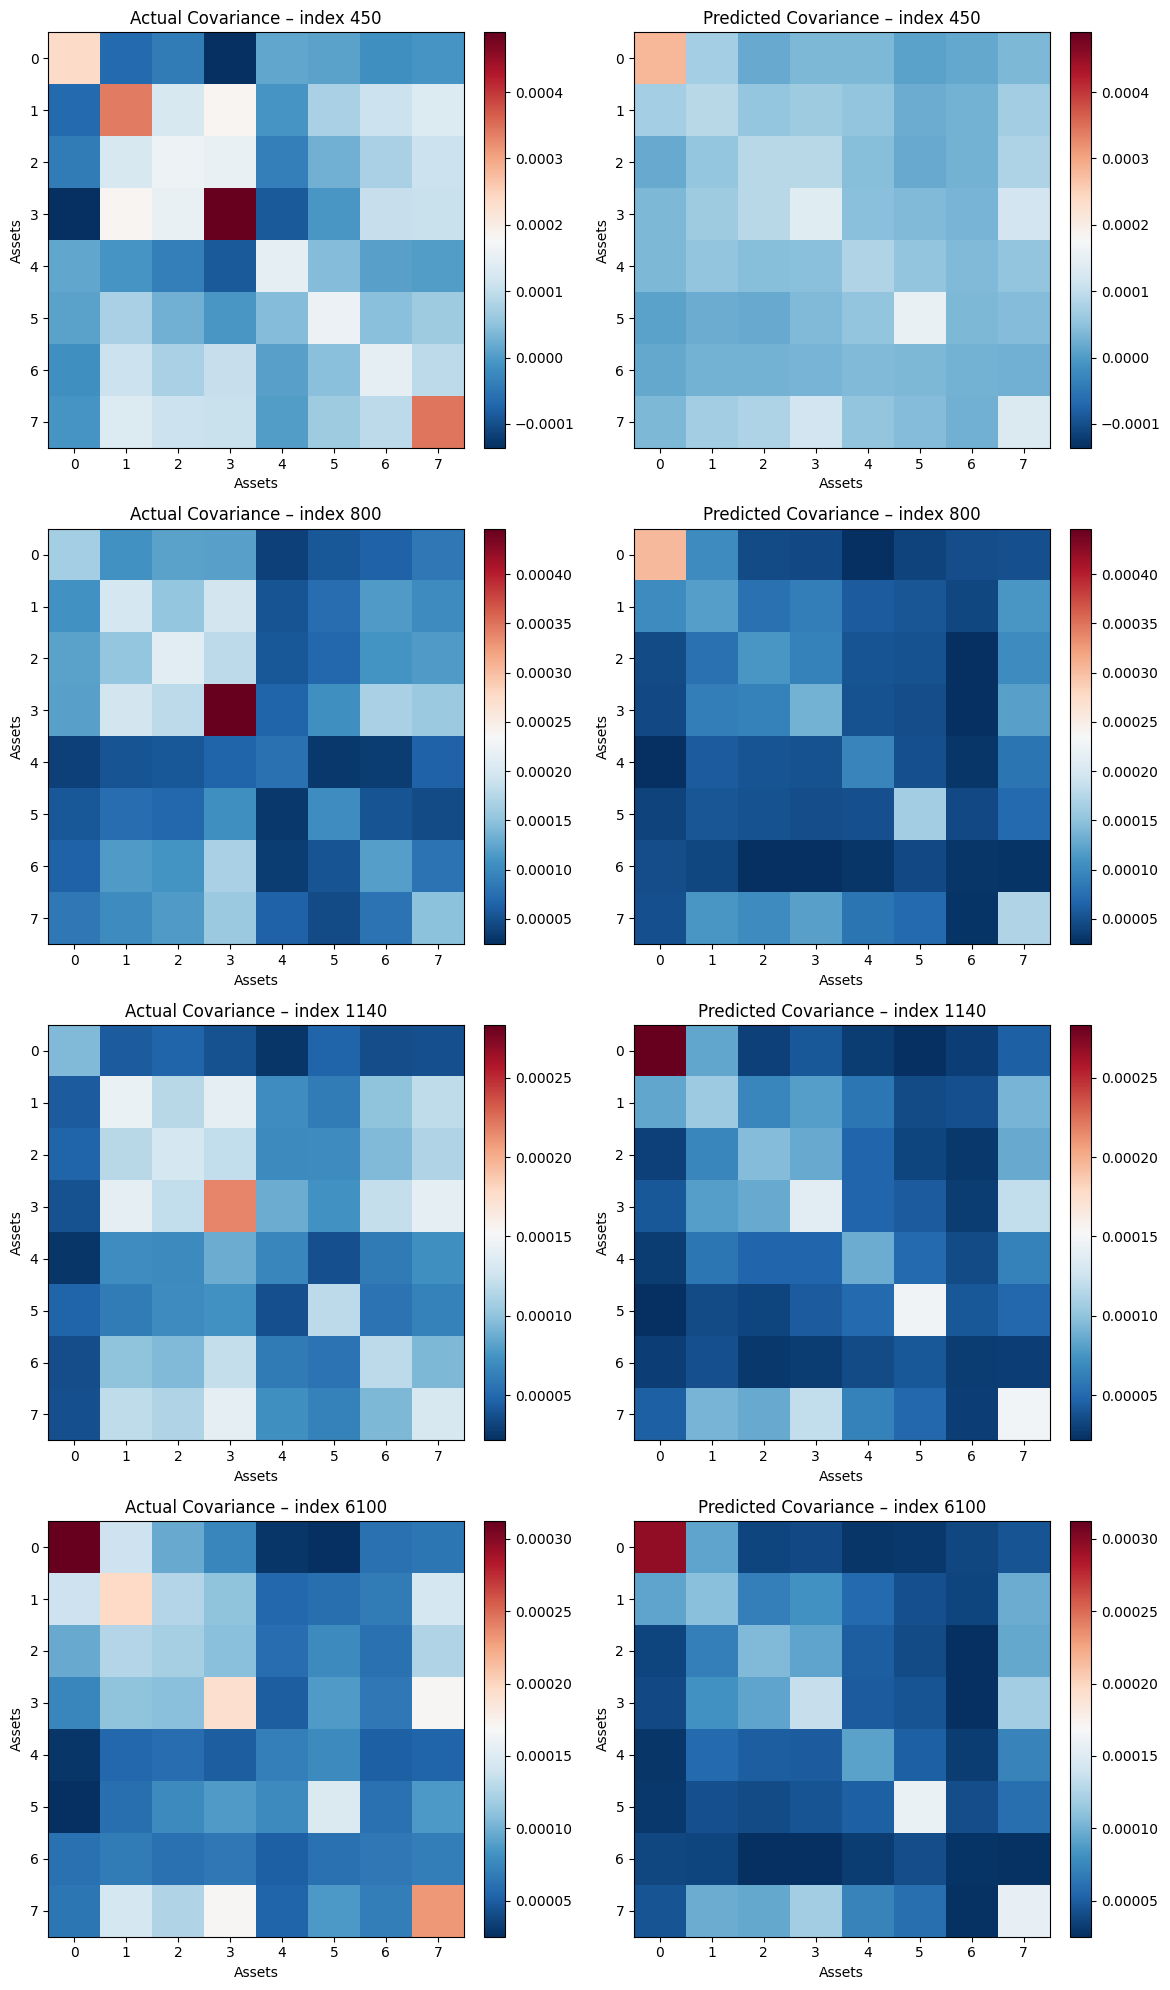

In [95]:
# Pick four time indices
i, j, k, t = 450, 800, 1140, 6100
indices = [i, j, k, t]


cmap_choice = "RdBu_r"
fig, axes = plt.subplots(len(indices), 2, figsize=(12, 5 * len(indices)))

for row, idx in enumerate(indices):
    # 1) Actual covariance (last 63 days)
    window = returns.iloc[idx - 63 : idx]
    actual_cov = window.cov().values

    # 2) Covariance predicted by the TCN
    predicted_cov = predict_next_day_cov(model, idx, returns, sequence_length)

    # 3) keep the same color scale for both matrices
    vmin = min(actual_cov.min(), predicted_cov.min())
    vmax = max(actual_cov.max(), predicted_cov.max())

    # plot ACTUAL
    im0 = axes[row, 0].imshow(actual_cov, cmap=cmap_choice, vmin=vmin, vmax=vmax)
    axes[row, 0].set_title(f"Actual Covariance – index {idx}")
    axes[row, 0].set_xlabel("Assets"); axes[row, 0].set_ylabel("Assets")
    fig.colorbar(im0, ax=axes[row, 0], fraction=0.046, pad=0.04)

    # plot PREDICTED
    im1 = axes[row, 1].imshow(predicted_cov, cmap=cmap_choice, vmin=vmin, vmax=vmax)
    axes[row, 1].set_title(f"Predicted Covariance – index {idx}")
    axes[row, 1].set_xlabel("Assets"); axes[row, 1].set_ylabel("Assets")
    fig.colorbar(im1, ax=axes[row, 1], fraction=0.046, pad=0.04)

    # 4) MAE × 10 000
    mae = np.mean(np.abs(actual_cov - predicted_cov)) * 10000
    print(f"Index {idx}: MAE × 10 000 = {mae:.2f}")

plt.tight_layout()
plt.show()


# 11) Testing in the Future
The model trained on data up to 31/03/2025, is being tested on live data

In [96]:
# CALCULATE MU HISTORICAL
returns_path = r"C:\Users\alpor\OneDrive\Desktop\politecnico\CORSI ERASMUS\MACHINE LEARNING\PROGETTO\tcn-portfolio v4\DATA\etf_returns_v4.csv"


returns = pd.read_csv(returns_path, index_col=0, parse_dates=True)
etf_columns = returns.columns.tolist()
returns.replace([np.inf, -np.inf], np.nan, inplace=True)
returns.dropna(inplace=True)

mu_historical = returns.mean().values

# Parameters
sequence_length = 63
window_size = 21
start_index = window_size + sequence_length
start_date = '2025-03-31'

# transaction cost per unit turnover 
transaction_cost = 0.195 / 100  # 0.00195 is a reasonable cost for a retail investor, 0.0005 for institutionals
slippage = 0.025 / 100
c = transaction_cost + slippage
# risk aversion
gamma = 4.5 #
# box constraints
lb, ub = -0.5, 0.75 

shrink_alpha = 0.025

tickers = ['XLF', 'XLK', 'XLE', 'XLU', 'XLI', 'XLV', 'XLY', 'XLP']


In [97]:

# Data Download
data = yf.download(
    tickers,
    start='2024-01-01',
    interval='1d',
    auto_adjust=True,
    progress=False
)['Close']

returns = np.log(data / data.shift(1)).dropna()
etf_columns = returns.columns.tolist()
print("✅ Log returns loaded. Shape:", returns.shape)


✅ Log returns loaded. Shape: (387, 8)


📁 Weights history saved in weights_history.csv
📁 Saved performance results to tangent_vs_benchmark_performance_live.csv

📊 Performance Metrics:
🔵 TCN Portfolio
  • Sharpe Ratio: -0.41
  • Volatility annualized: 2.89%
  • Max Drawdown: -13.35%

🟧 Equally-Weighted Benchmark
  • Sharpe Ratio: 0.25
  • Volatility annualized: 3.29%
  • Max Drawdown: -11.76%

🟩 SPY ETF
  • Sharpe Ratio: 0.43
  • Volatility: 4.04%
  • Max Drawdown: -12.05%



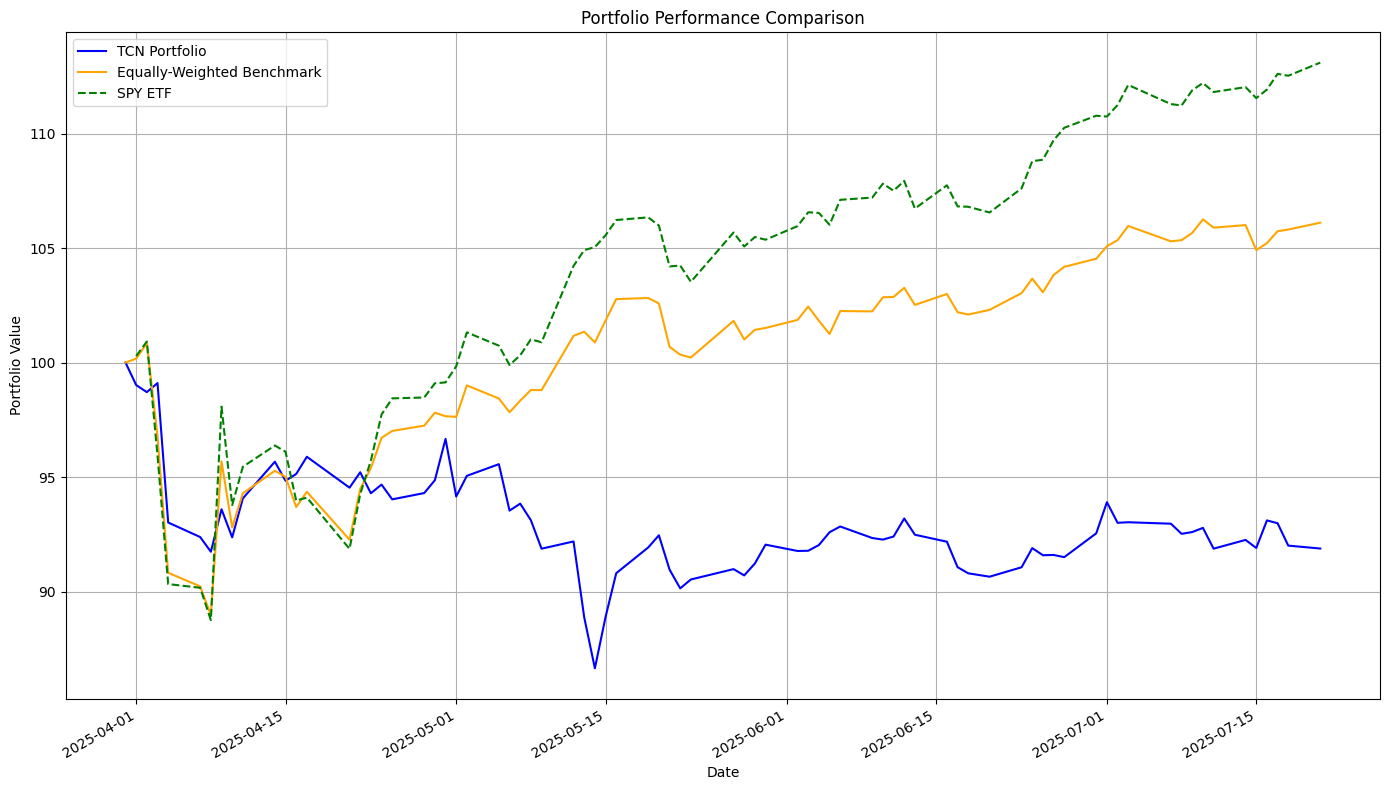

In [98]:
# FUNCTIONS

def predict_next_day_cov(model, i, returns_df, seq_len=63):
    cov_input = []
    for j in range(i - seq_len, i):
        window = returns_df.iloc[j - seq_len : j]
        cov = window.cov().values
        L = np.linalg.cholesky(cov + np.eye(cov.shape[0]) * 1e-7)

        # put the tensor on the same device as the model
        cov_input.append(torch.tensor(L, dtype=torch.float32, device=device))

    x_cov = torch.stack(cov_input).unsqueeze(0)      # (1, seq_len, n, n)
    with torch.no_grad():
        L_pred   = model(x_cov)                      # model and x_cov on same device
        cov_pred = torch.bmm(L_pred, L_pred.transpose(1, 2)) \
                      .squeeze(0).cpu().numpy()      # bring back to CPU only for NumPy
    cov_pred += np.eye(cov_pred.shape[0]) * 1e-7
    return cov_pred


def predict_next_day_global(i, returns_df, cov_length=180):
    """
    Use global mean + momentum EWMAs for mu, and predict cov via TCN.
    """
    ewma_span_1 = 30
    ewma_span_2 = 90
    ewma_span_3 = 180

    ewma_1 = returns.iloc[i - sequence_length : i].ewm(span=ewma_span_1, adjust=False).mean()
    mu_short_1 = ewma_1.iloc[-1].values

    ewma_2 = returns.iloc[i - sequence_length : i].ewm(span=ewma_span_2, adjust=False).mean()
    mu_short_2 = ewma_2.iloc[-1].values

    ewma_3 = returns.iloc[i - sequence_length : i].ewm(span=ewma_span_3, adjust=False).mean()
    mu_short_3 = ewma_3.iloc[-1].values

    mu_pred = mu_historical * (1 - 3 * shrink_alpha) + shrink_alpha * (mu_short_1 + mu_short_2 + mu_short_3)

    cov_pred = predict_next_day_cov(model, i, returns_df, seq_len=cov_length)
    return mu_pred, cov_pred


def turnover_penalized_weights(mu, cov, w_prev, gamma, turnover_cost, lb, ub):
    
    alpha = 0.3 # mix L1/L2: 1=L1 puro, 0=L2 puro
    beta = 0.6
    
    n = len(mu)
    w = cp.Variable(n)

    cost_turn = alpha * cp.norm1(w - w_prev) + (1-alpha) * cp.sum_squares(w - w_prev)

    obj = cp.Maximize(
        mu @ w
        - (gamma/2)*cp.quad_form(w, cov)
        - beta * turnover_cost * cost_turn
    )
    constraints = [
        cp.sum(w) == 1,
        w >= lb,
        w <= ub
    ]
    prob = cp.Problem(obj, constraints)
    prob.solve(solver=cp.SCS, verbose=False)
    return w.value 
    

# Main Loop
portfolio_values = []
benchmark_returns = []
portfolio_returns = []
dates = []
weights_list = []
w_prev = equal_weights  # initialization for the first day

portfolio_value = None
equal_weights = np.repeat(1 / len(etf_columns), len(etf_columns))

first_trade_done = False

for i in range(start_index, len(returns) - 1):
    mu_pred, cov_pred = predict_next_day_global(i, returns, cov_length=sequence_length)

    # penalty to 0 only on the first trade
    turnover_cost_eff = 0.0 if not first_trade_done else c
    
    weights = turnover_penalized_weights(
        np.asarray(mu_pred), cov_pred,
        np.asarray(w_prev),
        gamma,
        turnover_cost_eff,
        lb, ub
    )


    real_ret = returns.iloc[i + 1].values

    turnover = np.sum(np.abs(weights - w_prev))

    # SKip turnover if under threshold
    if turnover < 0.01:
        weights = w_prev  # do not update weights
        turnover = 0.0
        cost = 0.0
        portfolio_log_ret = weights @ real_ret
    else:
        cost = c * turnover
        portfolio_log_ret = weights @ (real_ret - np.log(1 - cost))
    
    w_prev = weights

    
    log_ret_bench = equal_weights @ real_ret
    date = returns.index[i + 1]

    if date == pd.to_datetime(start_date):
        portfolio_value = 100.0
        portfolio_values.append(portfolio_value)
        benchmark_returns.append(0)
        portfolio_returns.append(0)
        dates.append(date)
        weights_list.append(equal_weights)
        continue

    if portfolio_value is not None:
        first_trade_done = True
        portfolio_value *= np.exp(portfolio_log_ret)
        portfolio_returns.append(portfolio_log_ret)
        benchmark_returns.append(log_ret_bench)
        portfolio_values.append(portfolio_value)
        dates.append(date)
        weights_list.append(weights)


# Saving the Results
weights_df = pd.DataFrame(weights_list, columns=etf_columns, index=dates)
weights_df.index.name = "date"
weights_df.to_csv(
    r"C:\Users\alpor\OneDrive\Desktop\politecnico\CORSI ERASMUS\MACHINE LEARNING\PROGETTO\tcn-portfolio v4\DATA\weights_history_live.csv"
)
print("📁 Weights history saved in weights_history.csv")

benchmark_values = 100 * np.exp(np.cumsum(benchmark_returns))

performance = pd.DataFrame({
    'date': dates,
    'portfolio_value': portfolio_values,
    'benchmark_value': benchmark_values,
    'portfolio_return': portfolio_returns
}).set_index('date')

performance = performance[performance.index >= pd.to_datetime(start_date)]
performance.to_csv(
    r"C:\Users\alpor\OneDrive\Desktop\politecnico\CORSI ERASMUS\MACHINE LEARNING\PROGETTO\tcn-portfolio v4\DATA\tangent_vs_benchmark_performance_live.csv"
)
print("📁 Saved performance results to tangent_vs_benchmark_performance_live.csv")

# SPY Comparison
if not performance.empty:
    spy = yf.download(
    "SPY",
    start=(performance.index[0] - pd.Timedelta(days=1)).strftime('%Y-%m-%d'),  # per avere un punto precedente per log-ret
    end=(performance.index[-1] + pd.Timedelta(days=1)).strftime('%Y-%m-%d'),   # include anche l’ultimo giorno
    progress=False
)["Close"]

    spy = spy.ffill()
    spy = spy.loc[performance.index[0] - pd.Timedelta(days=1): performance.index[-1]]
    spy_returns = np.log(spy / spy.shift(1)).dropna()
    spy_value = 100 * np.exp(spy_returns.cumsum()).reindex(performance.index).ffill()
    performance["spy_value"] = spy_value


    def compute_metrics(values):
        log_ret = np.log(values / values.shift(1)).dropna()
        n = len(log_ret)
        multiplier = np.sqrt(365 / n)
        sharpe = 365 * log_ret.mean() / (log_ret.std() * n) if log_ret.std() != 0 else np.nan
        vol = log_ret.std() * multiplier
        drawdown = (values / values.cummax() - 1).min()
        return sharpe, vol, drawdown

    sharpe_tcn, vol_tcn, dd_tcn = compute_metrics(performance["portfolio_value"])
    sharpe_eqw, vol_eqw, dd_eqw = compute_metrics(performance["benchmark_value"])
    sharpe_spy, vol_spy, dd_spy = compute_metrics(performance["spy_value"])

    print("""
📊 Performance Metrics:
🔵 TCN Portfolio
  • Sharpe Ratio: {:.2f}
  • Volatility annualized: {:.2%}
  • Max Drawdown: {:.2%}

🟧 Equally-Weighted Benchmark
  • Sharpe Ratio: {:.2f}
  • Volatility annualized: {:.2%}
  • Max Drawdown: {:.2%}

🟩 SPY ETF
  • Sharpe Ratio: {:.2f}
  • Volatility: {:.2%}
  • Max Drawdown: {:.2%}
""".format(
        sharpe_tcn, vol_tcn, dd_tcn,
        sharpe_eqw, vol_eqw, dd_eqw,
        sharpe_spy, vol_spy, dd_spy
    ))
    # Convert it to a pure index (remove hours)
    
    performance.index = pd.to_datetime(performance.index).normalize()
    plt.figure(figsize=(14, 8))
    plt.plot(performance.index, performance["portfolio_value"], label="TCN Portfolio", color="blue")
    plt.plot(performance.index, performance["benchmark_value"], label="Equally-Weighted Benchmark", color="orange")
    plt.plot(performance.index, performance["spy_value"], label="SPY ETF", color="green", linestyle="dashed")
    
    plt.title("Portfolio Performance Comparison")
    plt.ylabel("Portfolio Value")
    plt.xlabel("Date")
    
    # Remove hours and set only yyyy-mm-dd
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gcf().autofmt_xdate()
    
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ DataFrame performance is empty, no data to plot or comparison with SPY.")